# Forecasting Dividends

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

In a [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) we found a mathematical formula for doing long-term stock forecasting. The formula was derived from the definition of annualized return and separated the stock-return into 3 components: Dividends, change in the Sales Per Share, and change in the P/Sales ratio. If you can predict these 3 components, then you can predict the future stock-return.

This paper is a basic statistical study of how to predict the future Dividends and Dividend Growth. [Another previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/05_Forecasting_PSales_Ratio.ipynb) studied how to predict the future P/Sales ratio, and 
[yet another paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/06_Forecasting_Sales_Growth.ipynb) studied how to predict the future Sales Growth.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display_jpeg

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm

# SimFin imports.
import simfin as sf
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.6.0'

## Config

Setup and configure the various Python packages we are using.

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data-Hub

We use [SimFin](https://github.com/SimFin/simfin) to easily load and process financial data with the following settings:

In [6]:
hub_args = \
{
    # We are interested in the US stock-market.
    'market': 'us',

    # Use last-known values to fill in missing values.
    'fill_method': 'ffill',

    # Refresh the fundamental datasets (Income Statements etc.)
    # every 30 days.
    'refresh_days': 30,

    # Refresh the dataset with shareprices every 10 days.
    'refresh_days_shareprices': 10
}

We can then create a `StockHub` object to handle all the data and signal processing:

In [7]:
%%time
hub = sf.StockHub(**hub_args)

CPU times: user 11 µs, sys: 2 µs, total: 13 µs
Wall time: 15.7 µs


## Signals

We can now use the stock-hub to calculate the signals that we will be using in our analysis, such as Sales Growth, Net Profit Margin, etc.

In [8]:
%%time
# Calculate Growth Signals.
# We set variant='quarterly' to get 4 data-points per year,
# but the data used to calculate the growth signals is TTM.
df_growth_signals = hub.growth_signals(variant='quarterly')

# Calculate Financial Signals. Also 4 data-points per year.
df_fin_signals = hub.fin_signals(variant='quarterly')

# Calculate the 1-year change in the Financial Signals.
df_fin_signals_chg = hub.fin_signals(variant='quarterly',
                                     func=sf.rel_change_ttm_1y)

# Rename columns for the 1-year changes.
def rename_chg(s):
    return s + ' (1Y Change)'
df_fin_signals_chg.rename(mapper=rename_chg, axis='columns', inplace=True)

# Combine all the signals we have calculated.
dfs = [df_growth_signals, df_fin_signals, df_fin_signals_chg]
df_signals1 = pd.concat(dfs, axis=1)

# Remove outliers using "Winsorization".
# The outliers are removed and not "clipped" because it distorts
# correlation-measures and line-fittings.
# We can also exclude some columns from the Winsorization.
exclude_columns = [LOG_REVENUE]
df_signals1 = sf.winsorize(df=df_signals1, clip=False,
                           exclude_columns=exclude_columns)

Dataset "us-income-ttm" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (16 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (16 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-52a73c0c.pickle' on disk (8 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-52a73c0c.pickle' on disk (8 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-6d9b5e29.pickle' on disk (8 days old).
- Loading from disk ... Done!
CPU times: user 3.56 s, sys: 157 ms, total: 3.72 s
Wall time: 3.71 s


## Extra Signals

Let us now create a new Pandas DataFrame for the extra signals that we need, which are not calculated by SimFin's built-in functions above. The new signals are:

- `DIVIDEND_1Y_PAST` is the cash dividends paid in the PAST 1 year.
- `DIVIDEND_1Y_FUTURE` is the cash dividends paid in the FUTURE 1 year.
- `LOG_DIVIDEND_1Y_PAST` is the Log10 of `DIVIDEND_1Y_PAST`.
- `LOG_DIVIDEND_1Y_FUTURE` is the Log10 of `DIVIDEND_1Y_FUTURE`.
- `DIVIDEND_GROWTH_1Y_PAST` is the PAST 1-year growth in dividends.
- `DIVIDEND_GROWTH_1Y_FUTURE` is the FUTURE 1-year growth in dividends.
- `DIVIDEND_GROWTH_3Y_PAST` is the PAST 1-3 year average growth in dividends.
- `DIVIDEND_GROWTH_3Y_FUTURE` is the FUTURE 1-3 year average growth in dividends.

Some of these signals will be calculated using SimFin's functions `sf.rel_change` and `sf.mean_log_change`. See the SimFin documentation [here](https://simfin.readthedocs.io/en/latest/rel_change.html) and [here](https://github.com/SimFin/simfin-tutorials/blob/master/03_Growth_Returns.ipynb) for a detailed explanation of what these functions are calculating, as it would be too lengthy to explain it here.

In [9]:
%%time
# Create a new DataFrame to hold the other signals.
# This will have the same index as the other DataFrame.
df_signals2 = pd.DataFrame(index=df_growth_signals.index)

# Load the Cash-Flow Statements TTM data.
df_cashflow_ttm = hub.load_cashflow(variant='ttm')

# Get the data for Cash Dividends Paid TTM.
# Note the negation because these amounts are negative.
df_dividend = -df_cashflow_ttm[DIVIDENDS_PAID]

# Cash Dividends Paid in the PAST year.
DIVIDEND_1Y_PAST = 'Dividend 1Y PAST'
df_signals2[DIVIDEND_1Y_PAST] = df_dividend

# Cash Dividends Paid in the FUTURE year.
DIVIDEND_1Y_FUTURE = 'Dividend 1Y FUTURE'
df_signals2[DIVIDEND_1Y_FUTURE] = \
    df_dividend.groupby(TICKER).shift(-4)

# Log10 of the Cash Dividends Paid in the PAST year.
LOG_DIVIDEND_1Y_PAST = 'Log Dividend 1Y PAST'
# Replace zeros with NaN to avoid inf-values.
df_div_nonzero = df_dividend.replace(0, np.nan)
df_log_div = np.log10(df_div_nonzero)
df_signals2[LOG_DIVIDEND_1Y_PAST] = df_log_div

# Log10 of the Cash Dividends Paid in the FUTURE year.
LOG_DIVIDEND_1Y_FUTURE = 'Log Dividend 1Y FUTURE'
df_signals2[LOG_DIVIDEND_1Y_FUTURE] = \
    df_log_div.groupby(TICKER).shift(-4)

# Calculate the PAST 1-year Dividend Growth.
DIVIDEND_GROWTH_1Y_PAST = 'Dividend Growth 1Y PAST'
df_signals2[DIVIDEND_GROWTH_1Y_PAST] = \
    sf.rel_change(df=df_div_nonzero, freq='ttm',
                  years=1, future=False)

# Calculate the FUTURE 1-year Dividend Growth.
DIVIDEND_GROWTH_1Y_FUTURE = 'Dividend Growth 1Y FUTURE'
df_signals2[DIVIDEND_GROWTH_1Y_FUTURE] = \
    sf.rel_change(df=df_div_nonzero, freq='ttm',
                  years=1, future=True)

# Calculate the PAST 3-year average Dividend Growth.
# These are ANNUALIZED growth-rates.
DIVIDEND_GROWTH_3Y_PAST = 'Dividend Growth 3Y Avg. PAST'
df_signals2[DIVIDEND_GROWTH_3Y_PAST] = \
    sf.mean_log_change(df=df_div_nonzero, freq='ttm', future=False,
                       min_years=1, max_years=3, annualized=True)

# Calculate the FUTURE 3-year average Dividend Growth.
# These are ANNUALIZED growth-rates.
DIVIDEND_GROWTH_3Y_FUTURE = 'Dividend Growth 3Y Avg. FUTURE'
df_signals2[DIVIDEND_GROWTH_3Y_FUTURE] = \
    sf.mean_log_change(df=df_div_nonzero, freq='ttm', future=True,
                       min_years=1, max_years=3, annualized=True)

# Limit / clip outliers for the Dividend Growth signals only.
columns = [DIVIDEND_GROWTH_1Y_PAST, DIVIDEND_GROWTH_1Y_FUTURE,
           DIVIDEND_GROWTH_3Y_PAST, DIVIDEND_GROWTH_3Y_FUTURE]
df_signals2 = sf.winsorize(df=df_signals2, clip=False,
                           columns=columns)

# Combine all the signals into one DataFrame.
dfs = [df_signals1, df_signals2]
df_signals = pd.concat(dfs, axis=1)

/home/magnus/anaconda3/envs/simfin/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/magnus/anaconda3/envs/simfin/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 8.94 s, sys: 27.8 ms, total: 8.97 s
Wall time: 8.96 s


These are the resulting signals for ticker MSFT:

In [10]:
df_signals.loc['MSFT'].dropna(how='all').tail()

,Assets Growth,Assets Growth QOQ,Assets Growth YOY,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,...,Return on Research Capital (1Y Change),Share Buyback / FCF (1Y Change),Dividend 1Y PAST,Dividend 1Y FUTURE,Log Dividend 1Y PAST,Log Dividend 1Y FUTURE,Dividend Growth 1Y PAST,Dividend Growth 1Y FUTURE,Dividend Growth 3Y Avg. PAST,Dividend Growth 3Y Avg. FUTURE
Report Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,0.011156,0.004813,0.011156,1.425410,-0.045784,-2.336084,-0.041491,-0.483541,-0.018151,0.158263,...,0.031859,1.116586,1.322200e+10,1.444300e+10,10.121297,10.159657,0.078291,0.092346,0.069179,NaN
2019-03-31,0.072441,0.017083,0.072441,1.215133,0.046200,0.186557,0.003131,1.109571,0.188565,0.154241,...,0.020304,0.761958,1.351600e+10,NaN,10.130848,NaN,0.082839,NaN,0.071127,NaN
2019-06-30,0.107044,0.088404,0.107044,1.367992,0.496992,0.486194,0.186283,0.100593,0.621000,0.140295,...,0.005004,0.595995,1.381100e+10,NaN,10.140225,NaN,0.087566,NaN,0.073401,NaN
2019-09-30,0.082820,-0.026525,0.082820,1.183644,-0.190263,0.210109,0.207475,-0.134694,0.037593,0.129741,...,-0.001006,0.489950,1.410100e+10,NaN,10.149250,NaN,0.091747,NaN,0.075721,NaN
2019-12-31,0.092463,0.013762,0.092463,0.321457,0.090935,0.383492,0.271981,-0.316112,0.373965,0.133295,...,0.027951,-0.057611,1.444300e+10,NaN,10.159657,NaN,0.092346,NaN,0.078906,NaN


## Data Years

Let us see how many years of data we have for all the different stocks. First we need a small helper-function:

In [11]:
def data_years(df):
    """
    Calculate the number of years of data in DataFrame `df`.
    
    :param df:
        Pandas DataFrame assumed to have TTM data and be
        grouped by TICKER, and not have any empty NaN rows.

    :return:
        Pandas Series with number of years for each TICKER.
    """

    # Count the number of data-points for each ticker.
    df_len_data = df.groupby(TICKER).apply(lambda df_grp: len(df_grp))

    # Calculate the number of years of data for each ticker.
    # TTM data has 4 data-points per year.
    df_data_years = df_len_data / 4
    
    return df_data_years

On average we have about 6 years of Dividend TTM data for all these stocks:

In [12]:
# Calculate number of years of Sales Growth data for all stocks.
df = df_signals[DIVIDEND_1Y_PAST].dropna()
df_data_years = data_years(df=df)

# Show statistics.
df_data_years.describe()

count    936.000000
mean       6.300214
std        3.083576
min        0.250000
25%        3.750000
50%        7.250000
75%        9.000000
max       10.750000
Name: Dividend 1Y PAST, dtype: float64

We can also plot a histogram, so we can see the distribution of how many years of data we have for all the individual companies:

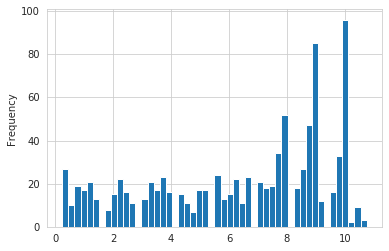

In [13]:
df_data_years.plot(kind='hist', bins=50);

In some of the plots further below, we will compare e.g. the PAST 1-year Dividend Growth to the FUTURE 3-year average Dividend Growth. The summary statistics below shows that on average there is about 3.5 years of such data per company, for a total of about 600 companies:

In [14]:
columns = [DIVIDEND_GROWTH_1Y_PAST, DIVIDEND_GROWTH_3Y_FUTURE]
df = df_signals[columns].dropna(how='any')
data_years(df=df).describe()

count    628.000000
mean       3.494825
std        1.817005
min        0.250000
25%        2.000000
50%        3.750000
75%        5.000000
max        6.750000
dtype: float64

Further below, we will also compare the PAST 3-year average Dividend Growth to the FUTURE 3-year average Dividend Growth. The statistics below show that there was only about 2.5 years of data-points per company, for a total of about 500 companies:

In [15]:
columns = [DIVIDEND_GROWTH_3Y_PAST, DIVIDEND_GROWTH_3Y_FUTURE]
df = df_signals[columns].dropna(how='any')
data_years(df=df).describe()

count    513.000000
mean       2.526316
std        1.284215
min        0.250000
25%        1.500000
50%        2.750000
75%        3.500000
max        5.000000
dtype: float64

This is a fairly short data-period, because the SimFin database currently does not have any more data. What this means for our analysis, is that we should interpret the results with some caution, as the data may contain trends that are unique for that period in time.

## Plotting Functions

These are small helper-functions for making plots.

In [16]:
def plot_scatter(df, x, y, hue=None, num_samples=5000):
    """
    Make a scatter-plot using a random sub-sample of the data.
    
    :param df:
        Pandas DataFrame with columns named `x`, `y` and `hue`.

    :param x:
        String with column-name for the x-axis.

    :param y:
        String with column-name for the y-axis.

    :param hue:
        Either None or string with column-name for the hue.

    :param num_samples:
        Int with number of random samples for the scatter-plot.

    :return:
        matplotlib Axes object
    """

    # Select the relevant columns from the DataFrame.
    if hue is None:
        df = df[[x, y]].dropna()
    else:
        df = df[[x, y, hue]].dropna()

    # Only plot a random sample of the data-points?
    if num_samples is not None and len(df) > num_samples:
        idx = np.random.randint(len(df), size=num_samples)
        df = df.iloc[idx]

    # Ensure the plotting area is a square.
    plt.figure(figsize=(5,5))

    # Make the scatter-plot.
    ax = sns.scatterplot(x=x, y=y, hue=hue, s=20,
                         data=df.reset_index())

    # Move legend for the hue.
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    return ax

In [17]:
def plot_scatter_fit(df, x, y, num_samples=5000):
    """
    Make a scatter-plot and fit a line through the points.
    
    If there are many data-points, you can use a random
    sample for the scatter-plot, but the linear formula
    is still found using all the data-points.
    
    :param df:
        Pandas DataFrame with columns named `x` and `y`.

    :param x:
        String with column-name for the x-axis.

    :param y:
        String with column-name for the y-axis.

    :param num_samples:
        Int with number of random samples for the scatter-plot.

    :return:
        matplotlib Axes object
    """
    
    # Select the relevant columns from the DataFrame.
    df = df[[x, y]].dropna(how='any').reset_index()

    # Fit a line through all the data-points and get stats.
    slope, intercept, r_value, p_value, std_err = \
        linregress(x=df[x], y=df[y])

    # Show the fitted line and its stats.
    msg = 'y = {0:.2f} * x + {1:.2f} (R^2={2:.2f}, p={3:.0e})'
    msg = msg.format(slope, intercept, r_value**2, p_value)
    print(msg)
    
    # Only plot a random sample of the data-points?
    if num_samples is not None and len(df) > num_samples:
        idx = np.random.randint(len(df), size=num_samples)
        df = df.iloc[idx]

    # Make the scatter-plot with a fitted line.
    # This uses the smaller sample of data-points.
    ax = sns.jointplot(x=x, y=y, kind='reg', data=df,
                       line_kws={'color': 'red'},
                       scatter_kws={'s': 2})

    return ax

## Regression Function

This is a small helper-function for doing multiple linear regression.

In [18]:
def regression(df, y, standardize=True, use_constant=True):
    """
    Perform multiple linear-regression on the given DataFrame.
    
    :param df:
        Pandas DataFrame with signals and returns.
        
    :param y:
        String with column-name for the dependent variable.
        This will be taken from the DataFrame `df`.
        
    :param standardize:
        Boolean whether to standardize the predictor variables
        so they have 0 mean and 1 standard deviation.

    :param use_constant:
        Boolean whether to add a 'Constant' column to
        find the bias.
    
    :return:
        StatsModels Regression Results.
    """
    
    # Remove rows with missing values.
    df = df.dropna(how='any').copy()

    # DataFrame for the x-signals.
    df_x = df.drop(columns=[y])
    
    # DataFrame for the y-signal.
    df_y = df[y]

    # Standardize the signals so they have mean 0 and std 1.
    if standardize:
        df_x = (df_x - df_x.mean()) / df_x.std()

    # Add a "constant" column so the regression can find the bias.
    if use_constant:
        df_x['Constant'] = 1.0

    # Perform the regression on this data.
    model = sm.OLS(df_y, df_x).fit()
    
    return model

## Past vs. Future Dividends

Let us first compare the PAST and FUTURE Dividends. The first scatter-plot shows the raw cash amounts in USD. This fits a straight line with $R^2$ nearly 1, so it is a really good fit. But it has a tremendous range of values between zero and 14b USD, and the majority of points are concentrated in a small value-range.

y = 1.05 * x + 13152720.73 (R^2=0.98, p=0e+00)


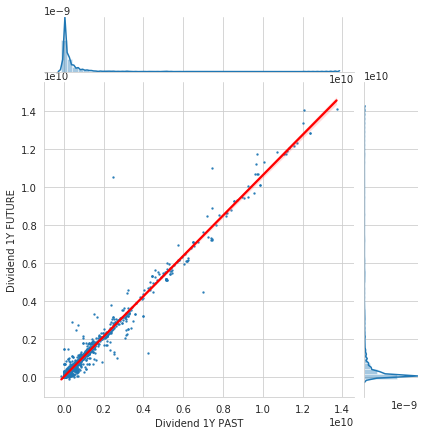

In [19]:
plot_scatter_fit(df=df_signals,
                 x=DIVIDEND_1Y_PAST,
                 y=DIVIDEND_1Y_FUTURE);

Let us instead try and plot the Log10 dividend amounts. This effectively shows the "number of zeros" so that 1 million becomes the value 6 because it has 6 zeros, and 1 billion becomes the value 9 because it has 9 zeros, etc.

This creates a more narrow range of values for the dividend amounts. But the line-fit is still nearly diagonal with $R^2$ near 1. This shows that the dividend amount tends to be almost the same from one year to the next, with only minor variation.

y = 0.98 * x + 0.21 (R^2=0.94, p=0e+00)


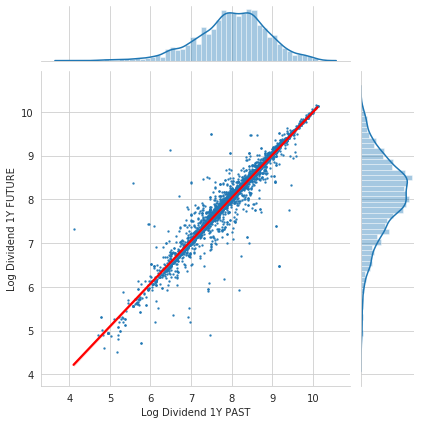

In [20]:
plot_scatter_fit(df=df_signals,
                 x=LOG_DIVIDEND_1Y_PAST,
                 y=LOG_DIVIDEND_1Y_FUTURE);

## Dividend Growth Statistics

Before we investigate whether some of the signals can be used to predict FUTURE Dividend Growth, let us consider some basic statistics. This shows that on average, the dividends have grown about 10.2% per year. Note that these are the total Cash Dividends Paid from the company's Cash-Flow Statement, it is NOT per-share numbers!

In [21]:
df_signals[DIVIDEND_GROWTH_1Y_FUTURE].describe()

count    17740.000000
mean         0.102350
std          0.148164
min         -0.327041
25%          0.015462
50%          0.074145
75%          0.152069
max          0.759348
Name: Dividend Growth 1Y FUTURE, dtype: float64

We can also show the distribution of 1-year Dividend Growth in a histogram:

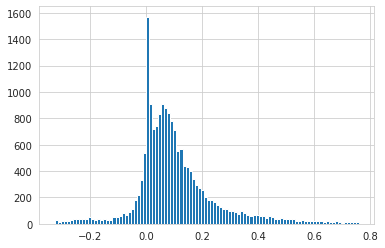

In [22]:
df_signals[DIVIDEND_GROWTH_1Y_FUTURE].hist(bins=100);

We can also show the basic statistics for 3-year average Dividend Growth. These are annualized numbers and show that on average the dividend grew about 10.3% when considering 3-year periods.

In [23]:
df_signals[DIVIDEND_GROWTH_3Y_FUTURE].describe()

count    11851.000000
mean         0.102646
std          0.111082
min         -0.242532
25%          0.031781
50%          0.086955
75%          0.159636
max          0.460588
Name: Dividend Growth 3Y Avg. FUTURE, dtype: float64

Once again we can show the distribution in a histogram:

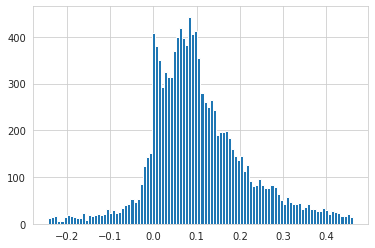

In [24]:
df_signals[DIVIDEND_GROWTH_3Y_FUTURE].hist(bins=100);

## Signal Correlation

Let us now investigate if any of the signals can be used to predict the FUTURE Dividend Growth for a company. First we calculate the linear correlations between the various signals and the FUTURE Dividend Growth.

In [25]:
%%time
df_corr = df_signals.corr()

# New column names.
SIGNALS_1Y = '1-Year Dividend Growth'
SIGNALS_3Y = '3-Year Avg. Dividend Growth'

# Create a new DataFrame with the correlations.
data = \
{
    SIGNALS_1Y: df_corr[DIVIDEND_GROWTH_1Y_FUTURE],
    SIGNALS_3Y: df_corr[DIVIDEND_GROWTH_3Y_FUTURE]
}
df = pd.DataFrame(data=data)

CPU times: user 428 ms, sys: 0 ns, total: 428 ms
Wall time: 430 ms


We can then show the correlations between the various signals and the FUTURE 1-year Dividend Growth and the FUTURE 3-year average Dividend Growth.

A correlation coefficient of 1 means the correlation is perfect so the two variables always move together, while a correlation of 0 means there is no linear relation between the two variables, and a correlation of -1 means the two variables always move perfectly opposite to each other.

We will show the absolute correlation values, because we are only concerned about the strength of the correlation and not its direction here.

In [26]:
df.abs().sort_values(by=SIGNALS_3Y, ascending=False)

,1-Year Dividend Growth,3-Year Avg. Dividend Growth
Dividend Growth 3Y Avg. FUTURE,0.755808,1.000000
Dividend Growth 1Y FUTURE,1.000000,0.755808
Dividend Growth 1Y PAST,0.304895,0.271199
Dividend Growth 3Y Avg. PAST,0.289479,0.258538
Log Revenue (1Y Change),0.180468,0.217491
Sales Growth,0.175427,0.213467
Sales Growth YOY,0.167108,0.204242
Dividends / FCF,0.115312,0.176547
Assets Growth YOY,0.160180,0.163269
Assets Growth,0.170497,0.155030


Let us try and fit a Linear Regression Model to some of the signals with highest correlation. The reason we don't fit the regression model to all the signals, is that a lot of them contain NaN (Not-a-Number), which results in the entire rows with NaN being removed, so the dataset becomes much smaller, and the correlation numbers already show that many of the signals are not linearly related to the FUTURE Dividend Growth anyway.

The regression model has $R^2 = 0.13$ which is quite weak. Because the data is standardized to having zero mean and one standard deviation before the regression model is fitted, the coefficients show us which signals are most important in predicting the FUTURE 1-year Dividend Growth, and that is by far the PAST 3-year average Dividend Growth, followed by the PAST 1-year Dividend Growth.

In [27]:
# Only use some of the signals in the regression.
columns = [DIVIDEND_GROWTH_1Y_FUTURE, DIVIDEND_GROWTH_1Y_PAST,
           DIVIDEND_GROWTH_3Y_PAST, SALES_GROWTH,
           PAYOUT_RATIO, ASSETS_GROWTH_YOY]

# Fit the regression model.
model = regression(df=df_signals[columns],
                   y=DIVIDEND_GROWTH_1Y_FUTURE, standardize=True)

# Show the results.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Dividend Growth 1Y FUTURE   R-squared:                       0.134
Model:                                   OLS   Adj. R-squared:                  0.133
Method:                        Least Squares   F-statistic:                     211.2
Date:                       Wed, 15 Apr 2020   Prob (F-statistic):          3.83e-210
Time:                               14:56:03   Log-Likelihood:                 5711.5
No. Observations:                       6859   AIC:                        -1.141e+04
Df Residuals:                           6853   BIC:                        -1.137e+04
Df Model:                                  5                                         
Covariance Type:                   nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Dividend Growth 1Y PAST          0.0130      0.002      6.660      0.000       0.009       0.017
Dividend Growth 3Y Avg. PAST     0.0232      0.002     11.926      0.000       0.019       0.027
Sales Growth                     0.0074      0.001      5.269      0.000       0.005       0.010
Dividends / FCF                 -0.0099      0.001     -7.690      0.000      -0.012      -0.007
Assets Growth YOY                0.0104      0.001      7.495      0.000       0.008       0.013
Constant                         0.0884      0.001     69.563      0.000       0.086       0.091
==============================================================================
Omnibus:                     2558.033   Durbin-Watson:                   0.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21391.372
Skew:                           1.555   Prob(JB):                         0.00
Kurtosis:                      11.073   Cond. No.                         2.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Past vs. Future Dividend Growth

Let us now study whether the PAST Dividend Growth can be used to predict the FUTURE Dividend Growth.

First compare the PAST and FUTURE 1-year Dividend Growth. The fitted line in this scatter-plot shows a positive correlation with $R^2 = 0.09$. Note that the plot only contains 5000 data-points that are randomly sampled from the full dataset of more than 13,000 points. But the linear formula printed above the plot is fitted to the entire dataset.

Each dot in the scatter-plot shows a single data-point, that is, the x-axis is the 1-year PAST Dividend Growth for a single company and one of its financial reports. The y-axis shows the 1-year Dividend Growth starting in the same quarter and going 1 year into the future.

y = 0.28 * x + 0.06 (R^2=0.09, p=8e-298)


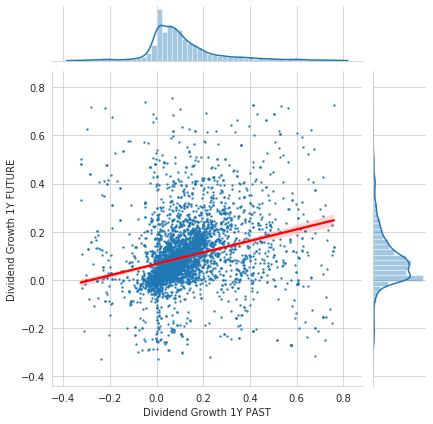

In [28]:
plot_scatter_fit(df=df_signals,
                 x=DIVIDEND_GROWTH_1Y_PAST,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

Let us now compare the PAST 3-year average Dividend Growth to the FUTURE 3-year average Dividend Growth. The plot looks quite similar to the one above for 1-year Dividend Growth. Once again there is a positive correlation and now with slightly lower $R^2 = 0.07$.

y = 0.27 * x + 0.06 (R^2=0.07, p=6e-80)


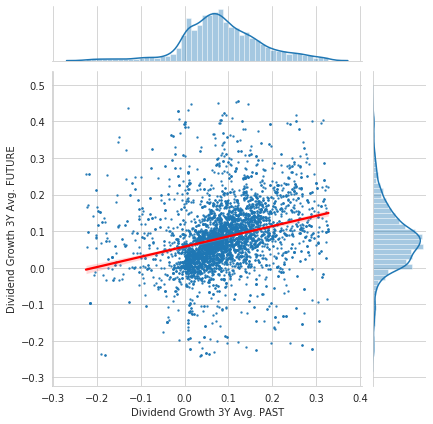

In [29]:
plot_scatter_fit(df=df_signals,
                 x=DIVIDEND_GROWTH_3Y_PAST,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

## Assets Growth YOY

Let us now consider if the Year-Over-Year (YOY) Assets Growth can predict the FUTURE 1-year Dividend Growth. This does not work very well, as the fitted line only has $R^2 = 0.03$.

y = 0.19 * x + 0.09 (R^2=0.03, p=4e-90)


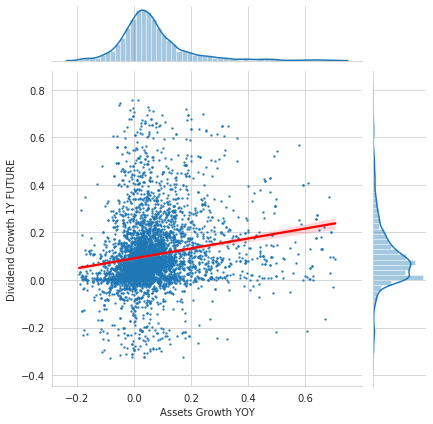

In [30]:
plot_scatter_fit(df=df_signals,
                 x=ASSETS_GROWTH_YOY,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

We can also try and see if the YOY Assets Growth can predict the FUTURE 3-year average Dividend Growth. Although there is a positive correlation, once again we get a very low $R^2$ near zero.

y = 0.15 * x + 0.09 (R^2=0.03, p=4e-62)


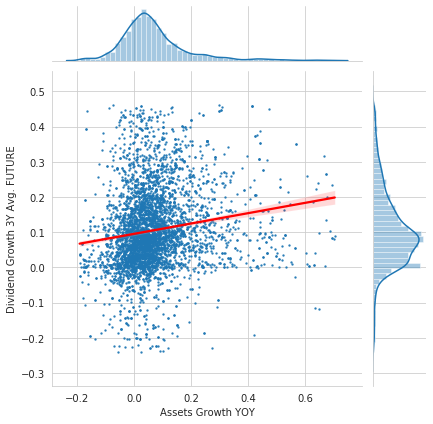

In [31]:
plot_scatter_fit(df=df_signals,
                 x=ASSETS_GROWTH_YOY,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

However, if we zoom in on the part of the plot where the YOY Assets Growth is greater than 0.2 (or 20%), we see that most FUTURE 1-year average Dividend Growths are greater than zero. This might be useful knowledge.

y = -0.04 * x + 0.15 (R^2=0.00, p=3e-01)


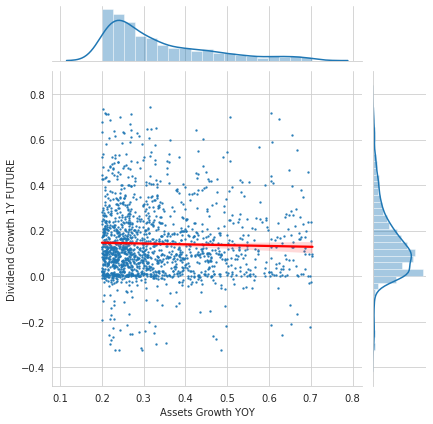

In [32]:
# Only use some of the data-points.
mask = (df_signals[ASSETS_GROWTH_YOY] > 0.2)
df = df_signals.loc[mask]

plot_scatter_fit(df=df,
                 x=ASSETS_GROWTH_YOY,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

We get a very similar plot when we compare the YOY Assets Growth that are greater than 0.2 to the FUTURE 3-year average Dividend Growth.

y = -0.03 * x + 0.14 (R^2=0.00, p=4e-01)


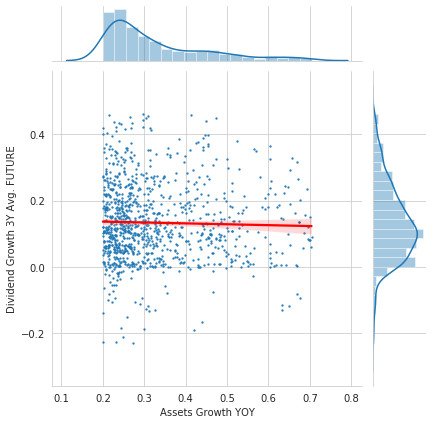

In [33]:
plot_scatter_fit(df=df,
                 x=ASSETS_GROWTH_YOY,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

## Sales Growth

Let us now consider if the TTM Sales Growth can predict the FUTURE 1-year Dividend Growth. There is a positive correlation but the fitted line only has $R^2 = 0.03$.

y = 0.24 * x + 0.09 (R^2=0.03, p=2e-102)


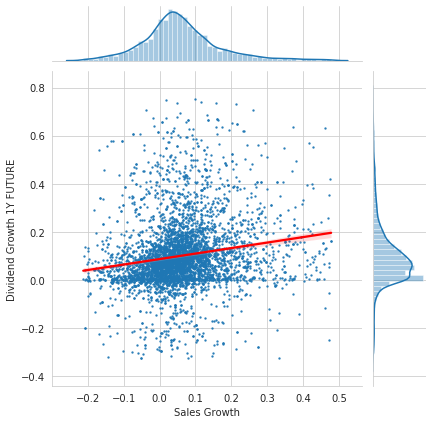

In [34]:
plot_scatter_fit(df=df_signals,
                 x=SALES_GROWTH,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

We can also try and see if the TTM Sales Growth can predict the FUTURE 3-year average Dividend Growth. Once again there is a positive correlation but we get a very low $R^2$ near zero.

y = 0.21 * x + 0.09 (R^2=0.05, p=9e-98)


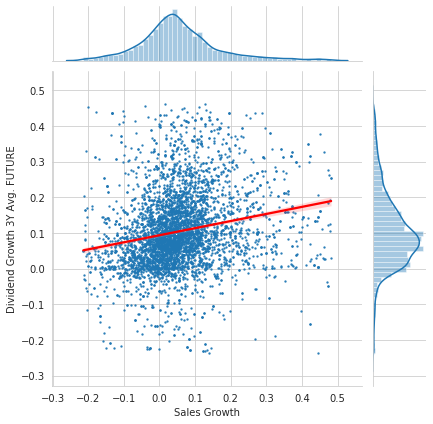

In [35]:
plot_scatter_fit(df=df_signals,
                 x=SALES_GROWTH,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

However, if we zoom in on the part of the plot where the TTM Sales Growth is greater than 0.1 (or 10%), we see that most FUTURE 1-year Dividend Growths are significantly greater than zero. This might be useful knowledge.

y = 0.04 * x + 0.13 (R^2=0.00, p=2e-01)


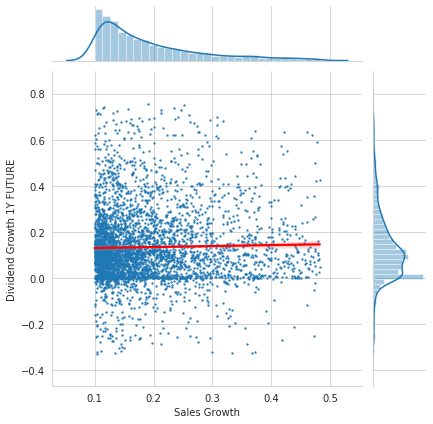

In [36]:
# Only use data-points with positive Sales Growth.
mask = (df_signals[SALES_GROWTH] > 0.1)
df = df_signals.loc[mask]

plot_scatter_fit(df=df,
                 x=SALES_GROWTH,
                 y=DIVIDEND_GROWTH_1Y_FUTURE);

We get a similar plot when we compare the positive TTM Sales Growth to the FUTURE 3-year average Dividend Growth.

y = 0.01 * x + 0.13 (R^2=0.00, p=8e-01)


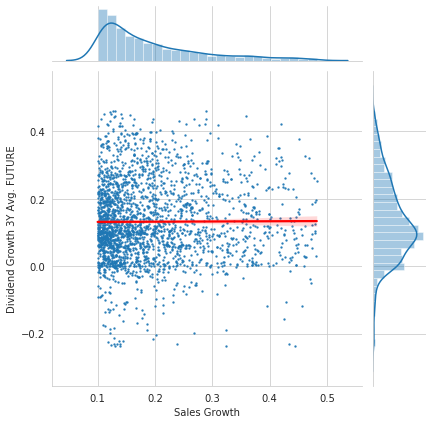

In [37]:
plot_scatter_fit(df=df,
                 x=SALES_GROWTH,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

## Dividend Payout Ratio

The Dividend Payout Ratio measures how much of the company's earnings are paid out as dividends to shareholders. We use a slightly different formula for the Payout Ratio than people normally use, as we use the Free Cash Flow instead of the reported Net Income:

$$
Payout\ Ratio = \frac{Dividends\ Paid\ TTM}{Free\ Cash\ Flow\ TTM} = \frac{Dividends\ Paid\ TTM}{Net\ Cash\ From\ Operations\ TTM - Capital\ Expenditures\ TTM}
$$

The scatter-plot shows a tendency for higher Dividend Payout Ratios to result in lower FUTURE 3-year average Dividend Growth, although the $R^2$ is nearly zero because the data-points are so dispersed.

y = -0.09 * x + 0.14 (R^2=0.03, p=1e-67)


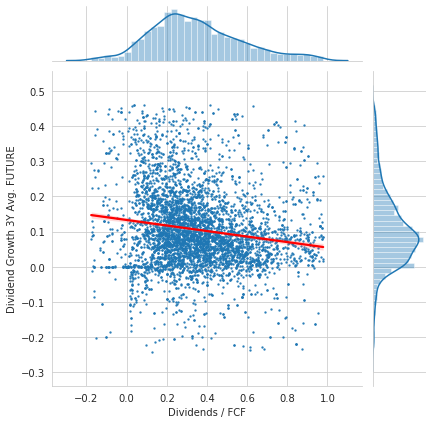

In [38]:
plot_scatter_fit(df=df_signals,
                 x=PAYOUT_RATIO,
                 y=DIVIDEND_GROWTH_3Y_FUTURE);

## Conclusion

Forecasting the Dividends is an essential component of long-term stock forecasting. This was a basic statistical study of which signals could be used to predict the FUTURE Dividends, as well as the FUTURE 1-year and 3-year average Dividend Growth.

These are the results:

- The PAST 1-year Dividend is a very strong predictor for the FUTURE 1-year Dividend with $R^2$ close to 1. Note that these are the total Cash Dividends Paid, which are the amounts taken from the Cash-Flow Statements. These are NOT the per-share Dividends which will also be affected by changes in share-counts e.g. from share buybacks, which may be studied in a future paper.

- The Dividend Growth is much harder to predict from the signals we considered here.

- The strongest predictor for the FUTURE 1-year Dividend Growth was the PAST 1-year Dividend Growth, but the data-points were so dispersed that $R^2 = 0.09$. Similarly, the strongest predictors for the FUTURE 3-year average Dividend Growth was the PAST 1-year Dividend Growth, but again with similar low $R^2$.

- The Year-Over-Year (YOY) Assets Growth was also a weak predictor for the FUTURE Dividend Growth. But only considering YOY Assets Growth greater than 20%, the FUTURE 1-year and 3-year average Dividend Growth was nearly always positive.

- Similarly, the Trailing-Twelve-Months (TTM) Sales Growth was also a weak predictor for the FUTURE Dividend Growth. But only considering TTM Sales Growth greater than 10%, the FUTURE 1-year and especially the FUTURE 3-year average Dividend Growth was nearly always positive.

Also note that we used data for a fairly short period of time, which ended in April 2020 and only went back about 6 years on average for the individual stocks, with the max period being 11 years for one stock. Ideally this kind of study would be done with 20-30 years of data, in which case we might be able to find stronger predictors for Dividend Growth over 5-10 year periods.

## License (MIT)

Copyright (c) 2020 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.